In [23]:
import torch
from torch.amp import GradScaler, autocast
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.utils import resample
import pandas as pd
import numpy as np
import evaluate

In [24]:
from transformers import AutoTokenizer, get_scheduler, AutoModelForSequenceClassification

model_choice = 'distilbert'  # 'bertimbau', 'distilbert', 'albertina'
train_size = 1000 # Terá 50% de cada label
batch_size = 4 # tamanho do batch pro treino (32 funciona pro bert, pra roBerTa é menos, isso tem a ver com a VRAM necessária)
max_length = 256 # tamanho máximo das sequencias de entrada pro modelo, se a entrada for maior, ele trunca.
num_workers = 8 # quantidade de workers (maior mais memoria gasta mais rapido o treino)

In [25]:
def evaluateModel(model, data_loader, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            logits = outputs.logits
            if logits.shape[1] == 1:  # Binary classification case
                predictions = (logits > 0).long().squeeze(1)  # Convert logits to binary predictions
            else:
                predictions = torch.argmax(logits, dim=1)  # Multiclass case
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    eval_pred = (np.array(all_predictions), np.array(all_labels))
    metrics = compute_metrics(eval_pred)
    return total_loss / len(data_loader), metrics

In [26]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [27]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1) if predictions.ndim > 1 else (predictions > 0).astype(int)
    
    f1_score = f1.compute(predictions=predictions, references=labels, average="weighted")
    precision_score = precision.compute(predictions=predictions, references=labels, average="weighted")
    recall_score = recall.compute(predictions=predictions, references=labels, average="weighted")
    accuracy_score = accuracy.compute(predictions=predictions, references=labels)

    return {
        'f1': f1_score['f1'],
        'precision': precision_score['precision'],
        'recall': recall_score['recall'],
        'accuracy': accuracy_score['accuracy'],
    }

In [28]:
accuracy = evaluate.load("accuracy")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")

df = pd.read_parquet('../reviews/reviews_cleaned.parquet')

num_samples = min(train_size, df['label'].value_counts().min())
undersampled_dfs = []

for label in df['label'].unique():
    df_label = df[df['label'] == label]
    if len(df_label) > num_samples:
        df_label = resample(df_label, 
                            replace=False, 
                            n_samples=num_samples, 
                            random_state=42)
    undersampled_dfs.append(df_label)

df = pd.concat(undersampled_dfs)

train_df, val_df = train_test_split(df, test_size=0.10, random_state=42)

if model_choice == 'bert':
    model_save_path = '../models/bert_model'
    tokenizer_save_path = '../models/bert_tokenizer'
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_save_path, clean_up_tokenization_spaces=True)
    model = AutoModelForSequenceClassification.from_pretrained(model_save_path)
elif model_choice == 'albertina':
    model_save_path = '../models/albertina-ptbr_model'
    tokenizer_save_path = '../models/albertina-ptbr_tokenizer'
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_save_path, clean_up_tokenization_spaces=True)
    model = AutoModelForSequenceClassification.from_pretrained(model_save_path)
elif model_choice == 'distilbert':
    model_save_path = '../models/distilbert_model'
    tokenizer_save_path = '../models/distilbert_tokenizer'
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_save_path, clean_up_tokenization_spaces=True)
    model = AutoModelForSequenceClassification.from_pretrained(model_save_path)
else:
    raise ValueError("Modelo desconhecido! Escolha entre 'bert', 'distilbert', ou 'albertina'.")


val_dataset = SentimentDataset(val_df['text'].tolist(), val_df['label'].tolist(), tokenizer, max_length=max_length)

val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


Evaluating:   0%|                                                                       | 0/50 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possibl

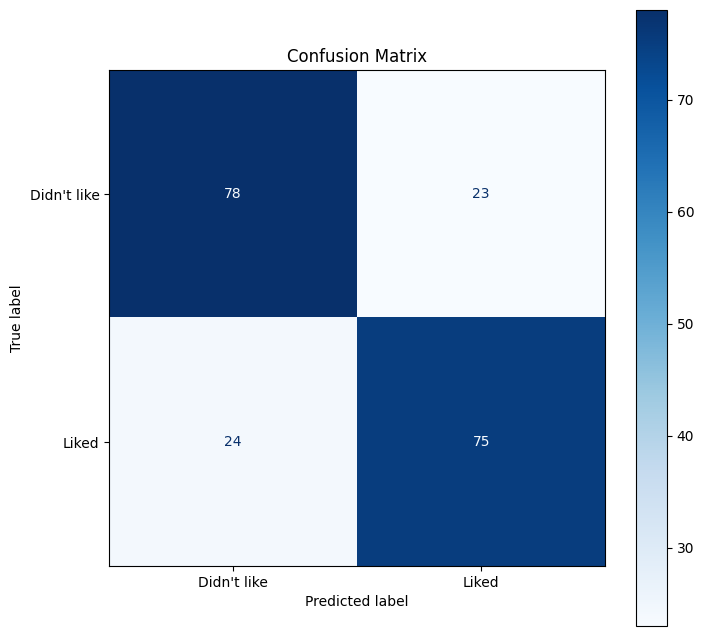

In [29]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating", leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_preds
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Didn't like", "Liked"])

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [37]:
model = AutoModelForSequenceClassification.from_pretrained('../models/model/')
tokenizer = AutoTokenizer.from_pretrained('../models/tokenizer')
model.to(device)

new_sample = "pra ser ruim tem que melhorar muito"

inputs = tokenizer(new_sample, return_tensors='pt', padding=True, truncation=True, max_length=512)

inputs = {key: value.to(device) for key, value in inputs.items()}

model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()

label_map = {0: "Negative", 1: "Positive"}
print(f"Prediction: {label_map[prediction]}")


Prediction: Negative


In [36]:
new_sample = "eu amei esse jogo estou viciado"

inputs = tokenizer(new_sample, return_tensors='pt', padding=True, truncation=True, max_length=512)

inputs = {key: value.to(device) for key, value in inputs.items()}

model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()

label_map = {0: "Negative", 1: "Positive"}
print(f"Prediction: {label_map[prediction]}")

Prediction: Positive
